## La Palma Eruption Figures and Analysis

#### Figures
1. top down kriging map (hope to see plume) on la palma photogrammetry
2. distance from launch & altitude kriging map - add sample data
3. 3D plots on imagry map
4. Highlight good gaussian fit (fig 3) next to all data combined (fig 7) - in context of all of the data (all combined) - divide into days, maybe add color to elevation

In [1]:
%matplotlib inline
# %matplotlib notebook
import os, sys, math, datetime, time
import scipy.stats as stats
import rasterio
from rasterio.plot import show
from scipy import optimize
import datetime as dt
import matplotlib.transforms as transforms
from matplotlib import pyplot as plt
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
})

module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)

from dragonfly_util.mplogtocsv import parse_mplog
from dragonfly_util.logtocsv import parse_log
from dragonfly_util.ortho_map import OrthoMap
from dragonfly_util.plot_util import *
from dragonfly_util.reading import Reading
from sklearn.linear_model import LinearRegression

In [2]:
# la_palma_map = OrthoMap([-18.058948516843866, -17.72935867309283], [28.537405559922902, 28.676808159899917], 'la_palma.png')
# la_palma_map = OrthoMap([-17.9728, -17.8252], [28.6483, 28.5929], 'la_palma_map.png')
# la_palma_map = OrthoMap([-17.9728, -17.8252], [28.6463, 28.5909], 'la_palma_map2.png')
la_palma_map_original = rasterio.open("la_palma_map4.tif")
la_palma_map = rasterio.open("la_palma_map4b.tif")

# maps = [la_palma_map]
# show(la_palma_map.read(), transform=la_palma_map_original.transform)

/usr/local/lib/python3.8/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [33]:
def read_data(file):
    return parse_log(file, skip_zeroing=False)

def filter_data(input, predicate):
    filtered = []
    for i in input:
        if predicate(i):
            filtered.append(i.data)
    return filtered

def between(start, end):
    start_date = datetime.datetime.strptime(start, '%Y-%m-%d %H:%M:%S.%f')
    end_date = datetime.datetime.strptime(end, '%Y-%m-%d %H:%M:%S.%f')
    return lambda value: value.type =='reading' and start_date <= value.date and end_date >= value.date and value.data.value > 0

def get_next_point(input, time):
    threshold_date = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f')
    for value in input:
        if value.time > threshold_date:
            return value
    return None

earthCircumference = 40008000
    
df3_data = read_data("la_palma_data/la palma 11-28-2021 - df3.log")
df4_data = read_data("la_palma_data/la palma 11-29-2021 - df4.log")

transect_1km_a = filter_data(df4_data, between('2021-11-26 12:31:27.020316', '2021-11-26 12:35:06.006446'))
transect_1km_b = filter_data(df4_data, between('2021-11-26 12:35:06.006446', '2021-11-26 12:40:31.575184'))
lapalma_flight1 = transect_1km_a + transect_1km_b

lapalma_flight2a = filter_data(df4_data, between('2021-11-26 12:48:30.019876', '2021-11-26 12:53:59.006718'))
lapalma_flight2b = filter_data(df4_data, between('2021-11-26 12:53:59.006718', '2021-11-26 12:58:59.005814'))

lapalma_flight3 = filter_data(df4_data, between('2021-11-27 10:04:25.135506', '2021-11-27 10:13:39.120506'))

lapalma_flight4 = filter_data(df3_data, between('2021-11-27 13:15:02.982099', '2021-11-27 13:27:34.548221'))

lapalma_flight5 = filter_data(df3_data, between('2021-11-27 16:05:08.784123', '2021-11-27 16:24:0.942152'))

first_plume = filter_data(df3_data, between('2021-11-27 16:06:00.0', '2021-11-27 16:08:00.0'))
curtain_plume = filter_data(df3_data, between('2021-11-27 16:07:50.0', '2021-11-27 16:12:20.0'))
returning_plume = filter_data(df3_data, between('2021-11-27 16:14:30.0', '2021-11-27 16:16:30.0'))

lapalma_flight6 = filter_data(df3_data, between('2021-11-28 12:29:14.86601', '2021-11-28 12:45:21.740369'))

lapalma_flight8 = filter_data(df4_data, between('2021-11-29 10:58:22.295029', '2021-11-29 11:05:33.152931'))

flight_list = [lapalma_flight1, 
               lapalma_flight2a, 
               lapalma_flight2b, 
               lapalma_flight3, 
               lapalma_flight4, 
               lapalma_flight5, 
               first_plume, 
               curtain_plume, 
               returning_plume, 
               lapalma_flight6, 
               lapalma_flight8]
flight_labels = ['flight 1', 'flight 2a', 'flight 2b', 'flight 3', 'flight 4', 'flight 5', 'fligh 6a', 'flight 6b', 'flight 6c', 'flight 6', 'flight 8']
all_data = [item for sublist in flight_list for item in sublist]

collection_point = get_next_point(lapalma_flight6, '2021-11-28 12:35:14.86601')
print(collection_point)

In [4]:
def display_lat_lon_datas(datas, names, legend=True):
    fig, ax = plt.subplots(figsize=(10, 4))
    
    max_lat = -360
    min_lat = 360
    max_lon = -360
    min_lon = 360
    for i in range(len(datas)):
        data = datas[i]
        lat_data = []
        lon_data = []
        for d in data:
            lat_data.append(d.lat)
            lon_data.append(d.lon)
            max_lat = max(max_lat, d.lat)
            min_lat = min(min_lat, d.lat)
            max_lon = max(max_lon, d.lon)
            min_lon = min(min_lon, d.lon)
    
        ax.scatter(lon_data, lat_data, s=1, label=names[i])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    if legend:
        ax.legend()
#     plot_maps(fig, ax, ortho_maps)
    show(la_palma_map.read(), ax=ax)
              
    dlat = max_lat - min_lat
    dlon = max_lon - min_lon
    lat_margin_scale = 2
    lon_margin_scale = 1
    minimum_size = 0.001

    dlat = max(max(dlat, dlon), minimum_size)
    dlon = max(dlat, dlon)

    ax.set_xlim(min_lon - (lon_margin_scale * dlon), max_lon + (lon_margin_scale * dlon))
    ax.set_ylim(min_lat - (lat_margin_scale * dlat), max_lat + (lat_margin_scale * dlat))

#     geo_axis_format(ax)
    ax.plot()
    

    
# display_lat_lon_datas(flight_list, flight_labels)
# plt.savefig("lat_lon_datas.pdf", format="pdf")

/home/john/dev/lapalma-expedition/dragonfly_util/plot_util.py:195: UserWarning: Trying to register the cmap 'reds_alpha' which already exists.
  plt.register_cmap(cmap=reds_map_object)
/home/john/dev/lapalma-expedition/dragonfly_util/plot_util.py:197: UserWarning: Trying to register the cmap 'blues_alpha' which already exists.
  plt.register_cmap(cmap=blues_map_object)


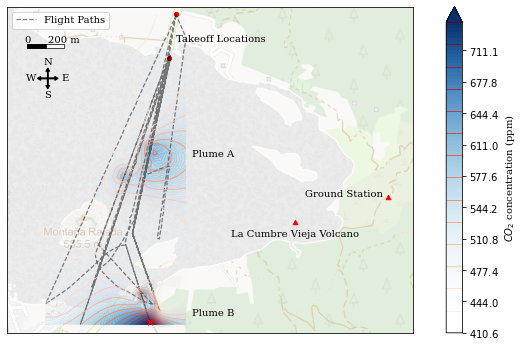

In [64]:
def zoom_to_data(ax, data):
    max_lat = -360
    min_lat = 360
    max_lon = -360
    min_lon = 360
    for d in data:
        max_lat = max(max_lat, d.lat)
        min_lat = min(min_lat, d.lat)
        max_lon = max(max_lon, d.lon)
        min_lon = min(min_lon, d.lon)

    dlat = max_lat - min_lat
    dlon = max_lon - min_lon
    lat_margin_scale = 0.2
    lon_margin_scale = 1.5
    minimum_size = 0.001

    dlat = max(max(dlat, dlon), minimum_size)
    dlon = max(dlat, dlon)

    ax.set_xlim(min_lon - (lon_margin_scale * dlon), max_lon + (lon_margin_scale * dlon))
    ax.set_ylim(min_lat - (lat_margin_scale * dlat), max_lat + (lat_margin_scale * dlat))
    print((min_lon - (lon_margin_scale * dlon)))
    print((max_lon + (lon_margin_scale * dlon)))
    print((min_lat - (lat_margin_scale * dlat)))
    print((max_lat + (lat_margin_scale * dlat)))
    
def add_compass(plt, ax) :
    
    unit = (plt.xlim()[1] - plt.xlim()[0]) * 0.05
    center = [plt.xlim()[0] + (plt.xlim()[1] - plt.xlim()[0]) *.1, 
             plt.ylim()[1] - (plt.ylim()[1] - plt.ylim()[0]) *.22]
    
    ax.arrow(center[0] - unit/2, center[1], unit, 0, head_width=unit * 0.2, head_length=unit * 0.15, width=unit * 0.03, length_includes_head=True, color='black')
    ax.arrow(center[0] + unit/2, center[1], -unit, 0, head_width=unit * 0.2, head_length=unit * 0.15, width=unit * 0.03, length_includes_head=True, color='black')
    ax.arrow(center[0], center[1] - unit/2, 0, unit, head_width=unit * 0.2, head_length=unit * 0.15, width=unit * 0.03, length_includes_head=True, color='black')
    ax.arrow(center[0], center[1] + unit/2, 0, -unit, head_width=unit * 0.2, head_length=unit * 0.15, width=unit * 0.03, length_includes_head=True, color='black')

    ax.annotate('N', xy=(center[0], center[1] + unit/1.2), ha='center', va='center')
    ax.annotate('E', xy=(center[0] + unit/1.2, center[1]), ha='center', va='center')
    ax.annotate('S', xy=(center[0], center[1] - unit/1.2), ha='center', va='center')
    ax.annotate('W', xy=(center[0] - unit/1.2, center[1]), ha='center', va='center')
    
    
def add_ruler2(plt, ax, length):
    height_scale = 0.7
    lowerleft = [plt.xlim()[0], plt.ylim()[0]]
    upperright = [plt.xlim()[1], plt.ylim()[1]]

    # Calculate width by latitide
    width = abs(1.0 * length / ((earthCircumference / 360) * math.cos(lowerleft[1] * 0.01745)))
    height = (upperright[1] - lowerleft[1]) * 0.018 * height_scale

    location = [plt.xlim()[0] + (plt.xlim()[1] - plt.xlim()[0]) *.05,
                plt.ylim()[1] - ((plt.ylim()[1] - plt.ylim()[0]) *(.1 + (height_scale * .04)))]

    ax.add_patch(Rectangle(location, width, height, ec=(0,0,0,1), fc=(1,1,1,1), lw=height_scale))
    ax.add_patch(Rectangle(location, width/2, height, ec=(0,0,0,1), fc=(0,0,0,1), lw=height_scale))
    ax.annotate("0", xy=(location[0], location[1] + (1.5 * height)), ha='center')
    ax.annotate("{} m".format(length), xy=(location[0] + width, location[1] + (1.5 * height)), ha='center')
    

def display_readings_krige2(name, readings, flights, nlags=6, minco2=None, maxco2=None, addons=None):
    fig, ax = plt.subplots(figsize=(12, 6))

#     plot_maps(fig, ax, ortho_maps)
    show(la_palma_map.read(), ax=ax, transform=la_palma_map_original.transform, alpha=0.35)
    
    ax.plot([d.lon for d in flights], [d.lat for d in flights], color='k', linestyle='--', lw=1.2, alpha=0.5, label="Flight Paths")

    plot_krige(name, fig, ax, [r.lon for r in readings], [r.lat for r in readings], [r.value for r in readings], nlags, minco2, maxco2, paths_lons=[r.lon for r in flights], paths_lats=[r.lat for r in flights])

    ax.set_xlim(-17.883, -17.86)
    ax.set_ylim(28.6065, 28.625)
#     zoom_to_data(ax, readings)
    geo_axis_format(ax)

#     def marker_right(position, text, marker='^'):
#         ax.scatter(position[0], position[1], s=20, color='r', marker=marker)
#         ax.annotate(text, position, (position[0] + 0.00025, position[1] + 0.000), ha='left')

    def marker_left(position, text, marker='^'):
        ax.scatter(position[0], position[1], s=20, color='r', marker=marker)
        ax.annotate(text, position, (position[0] - 0.00025, position[1] + 0.000), ha='right')
        
    def marker_center(position, text, marker='^'):
        ax.scatter(position[0], position[1], s=20, color='r', marker=marker)
        ax.annotate(text, position, (position[0], position[1] - 0.0008), ha='center')
        
    # Ground station
#     marker_right([-17.8743, 28.621], "Takeoff Location", marker='8')
    ax.annotate("Takeoff Locations", [-17.8737, 28.623], (-17.8737 + 0.00025, 28.623), ha='left')
    ax.scatter(-17.8738061, 28.6220798, s=20, color='r', marker='8')
    ax.scatter(-17.8734256, 28.6245778, s=20, color='r', marker='8')
    marker_left([-17.861408, 28.614214], "Ground Station")
    marker_center([-17.866684021210542, 28.61277150738451], "La Cumbre Vieja Volcano")
    
    ax.annotate("Plume A", [-17.8725, 28.6165])
    ax.annotate("Plume B", [-17.8725, 28.6075])
    
    ax.scatter(collection_point.lon, collection_point.lat, s=30, color='r', marker='x', zorder=2)
    
    ax.legend(loc="upper left")
    
    add_ruler2(plt, ax, 200)
    add_compass(plt, ax)
    
    if addons is not None:
        addons(plt, fig, ax)

    ax.plot()
    
combined_data = [item for item in all_data if item.value > 430]
# combined_data = all_data[0::10]
limited_all_data = [item for item in all_data if item.lat > 28.607]

display_readings_krige2('la palma top', combined_data, limited_all_data)
plt.savefig("lat_lon_krig.pdf", format="pdf", dpi=300)

/home/john/dev/lapalma-expedition/dragonfly_util/plot_util.py:195: UserWarning: Trying to register the cmap 'reds_alpha' which already exists.
  plt.register_cmap(cmap=reds_map_object)
/home/john/dev/lapalma-expedition/dragonfly_util/plot_util.py:197: UserWarning: Trying to register the cmap 'blues_alpha' which already exists.
  plt.register_cmap(cmap=blues_map_object)


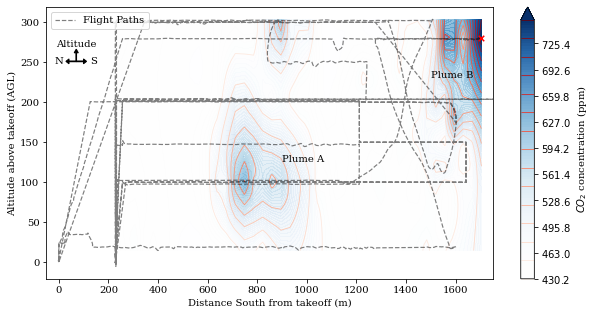

In [61]:
def add_alt_compass(plt, ax) :
    
    x_unit = (plt.xlim()[1] - plt.xlim()[0]) * 0.04
    y_unit = (plt.ylim()[1] - plt.ylim()[0]) * 0.09
    center = [plt.xlim()[0] + (plt.xlim()[1] - plt.xlim()[0]) *.08, 
             plt.ylim()[1] - (plt.ylim()[1] - plt.ylim()[0]) *.2]
    
    ax.arrow(center[0], center[1], 0, y_unit/2, head_width=x_unit * 0.2, head_length=y_unit * 0.15, width=x_unit * 0.03, length_includes_head=True, color='black')
    ax.arrow(center[0], center[1], -x_unit/2, 0, head_width=y_unit * 0.2, head_length=x_unit * 0.15, width=y_unit * 0.03, length_includes_head=True, color='black')
    ax.arrow(center[0], center[1], x_unit/2, 0, head_width=y_unit * 0.2, head_length=x_unit * 0.15, width=y_unit * 0.03, length_includes_head=True, color='black')

    ax.annotate('Altitude', xy=(center[0], center[1] + y_unit/1.4), ha='center', va='center')
    ax.annotate('S', xy=(center[0] + x_unit/1.2, center[1]), ha='center', va='center')
    ax.annotate('N', xy=(center[0] - x_unit/1.2, center[1]), ha='center', va='center')
    
def display_altitude_distance_krig(name, starting_position, readings, all_data, nlags=6, minco2=None, maxco2=None, addons=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    distance_data = []
    co2 = []
    altitude = []
    
    for i in range(len(readings)):
        d = readings[i]
        lat_diff = (starting_position.lat - d.lat) * (earthCircumference / 360) * math.cos(starting_position.lat * 0.01745)
        lon_diff = (starting_position.lon - d.lon) * (earthCircumference / 360)
        distance = lat_diff
        distance_data.append(distance)
        altitude.append(d.alt - starting_position.alt)
        co2.append(float(d.value))

    plot_krige(name, fig, ax, distance_data, altitude, co2, nlags, minco2, maxco2)
        
    path_distance = []
    path_alt = []
    for i in range(len(all_data)):
        d = all_data[i]
        lat_diff = (starting_position.lat - d.lat) * (earthCircumference / 360) * math.cos(starting_position.lat * 0.01745)
        lon_diff = (starting_position.lon - d.lon) * (earthCircumference / 360)
        distance = lat_diff
        path_distance.append(distance)
        path_alt.append(d.alt - starting_position.alt)
        co2.append(float(d.value))
    
    ax.plot(path_distance, path_alt, color='k', linestyle='--', lw=1.2, alpha=0.5, label="Flight Paths")

#     zoom_to_data(ax, readings)
#     geo_axis_format(ax)
    if addons is not None:
        addons(plt, fig, ax)
    
    ax.legend(loc="upper left")
    
    add_alt_compass(plt, ax)
    
    ax.set_xlim(-50, 1750)
    
    
    ax.annotate("Plume A", [900, 125])
    ax.annotate("Plume B", [1500, 230])
    
    collection_point_distance = (starting_position.lat - collection_point.lat) * (earthCircumference / 360) * math.cos(starting_position.lat * 0.01745)
    
    ax.scatter(collection_point_distance, collection_point.alt - starting_position.alt, s=30, color='r', marker='x', zorder=2)
    

    ax.set_xlabel('Distance South from takeoff (m)')
    ax.set_ylabel('Altitude above takeoff (AGL)')
    ax.plot()

minco2 = min([reading.value for reading in combined_data])
maxco2 = max([reading.value for reading in combined_data]) / 1.6

display_altitude_distance_krig('lapalma_combined2', lapalma_flight6[0], combined_data, all_data)
plt.savefig("altitude_krig.pdf", format="pdf")

Flight 1 Transect 1, A, 982.98, 102.67, 3544.35, 5891.57, 30758.37, 103969.19
Flight 2 Transect 2, A, 516.95, 57.21, 12793.28, 12540.32, 20711.19, 471042.00
Flight 2 Transect 2+3, A, 470.70, 123.51, 15395.94, 13511.23, 395835.71, 546804.43
Flight 2 Transect 3, A, 255.04, 118.63, 2602.41, 3325.45, 10641.57, 33124.05
Flight 3 Transect 4, A, 101.30, 257.57, 399.32, 898.50, 736.77, 2418.14
Flight 4 Transect 5, A, 1010.39, 103.17, 10118.47, 5701.41, 62467.44, 97366.10
Flight 5 Transect 6 + 7 + 8, A+B, 990.51, 351.85, 83111.56, 41563.26, 8687777.48, 5174421.02
Flight 5 Transect 6, A, 597.27, 108.03, 40807.34, 39738.21, 425245.24, 4729978.38
Flight 5 Transect 7, B, 1414.35, 116.19, 15364.54, 12269.92, 1964320.53, 450947.30
Flight 5 Transect 8, A, 682.30, 62.01, 15847.35, 15746.44, 276950.53, 742689.09
Flight 6 Transect 9, B, 1703.81, 225.77, 64928.77, 88214.55, 18077998.66, 23308963.40
Flight 8 Transect 10, A, 1116.22, 38.83, 2431.38, 2350.53, 141643.80, 16549.12


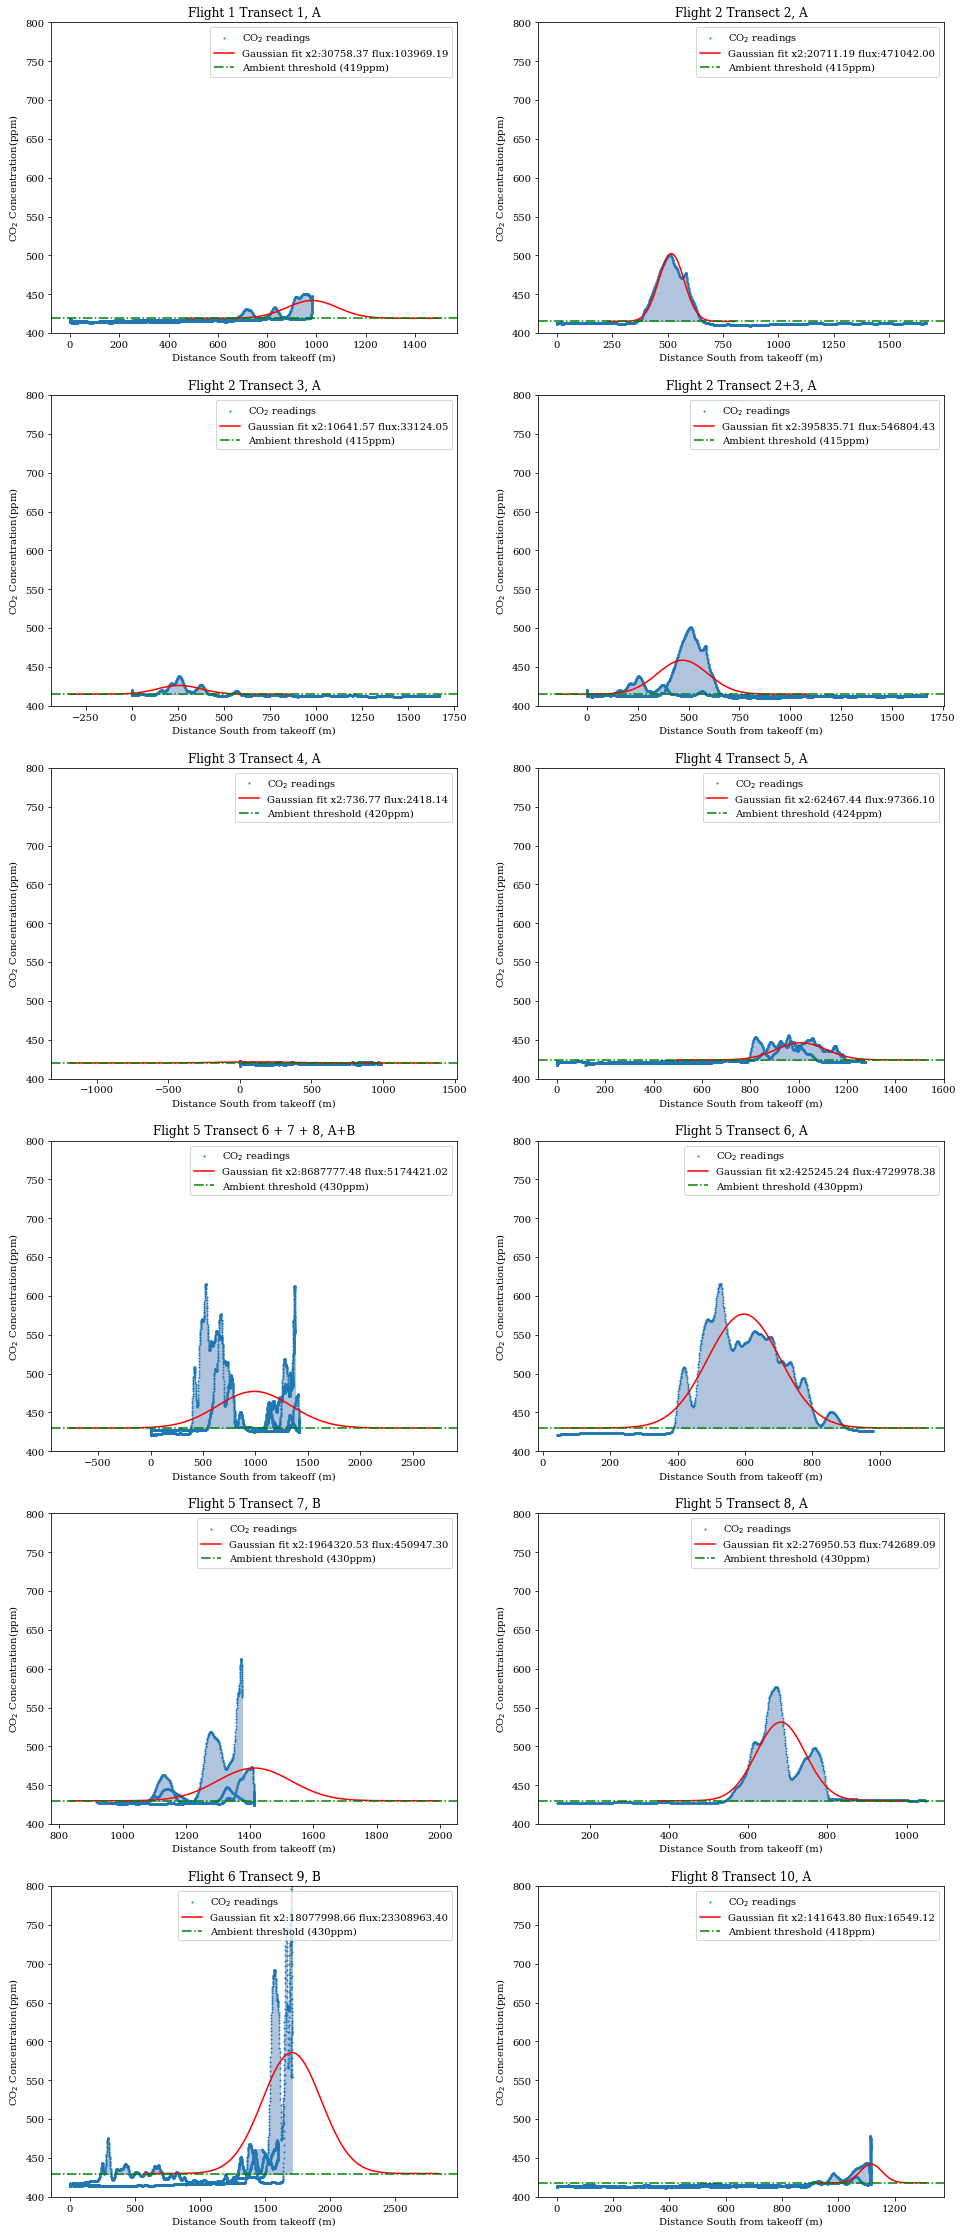

In [30]:
def render_distance_data(starting_position, data, ambient, title, ax, min_distance=0, limit_distance=None, legend=True, use_max=False, plot_gaussian=True, max_co2=800, delegate=None):
    total = 0
    count = 0
    
    
    
    distance_data = []
    max_distance = 0
    for d in data:
        lat_diff = (starting_position.lat - d.lat) * (earthCircumference / 360) * math.cos(starting_position.lat * 0.01745)
#         lat_diff = (starting_position.lat - d.lat) * (earthCircumference / 360) * math.cos(starting_position.lat * 0.01745)
#         lon_diff = (starting_position.lon - d.lon) * (earthCircumference / 360)
#         distance = math.sqrt((lat_diff*lat_diff) + (lon_diff*lon_diff))
        distance = lat_diff
        if distance > min_distance:
            distance_data.append({"distance": distance, "value": d.value})
            if(distance > max_distance):
                max_distance = distance
            
#     distance_data.sort(key=lambda v: v["distance"])
            
    for i in range(len(distance_data)):
        if distance_data[i]["value"] > ambient:
            relative_co2 = distance_data[i]["value"] - ambient
            total = total + (relative_co2 * distance_data[i]["distance"])
            count = count + relative_co2
            
#     print(count)
        
    mean = max_distance if use_max else total / count
    
    std_total = 0
    for i in range(len(distance_data)):
        if distance_data[i]["value"] > ambient:
            relative_co2 = distance_data[i]["value"] - ambient
            distance_diff = distance_data[i]["distance"] - mean
            std_total = std_total + (relative_co2 * (distance_diff * distance_diff))
    m = len(distance_data)
#     print("m: {} count: {}".format(m, count))
    std_dev = math.sqrt(std_total / (((m-1) / m) * count))
    
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(((-(((x - mean) / stddev) ** 2)) / 2)) / (stddev * math.sqrt(2 * math.pi))


    def difference(s):
        difference_sum = 0
        for i in range(len(distance_data)) :
            if distance_data[i]["value"] > ambient:
                calculated_value = gaussian(distance_data[i]["distance"], s, mean, std_dev)
                calculated_difference = distance_data[i]["value"] - ambient
                difference = calculated_value - calculated_difference
                difference_sum = difference_sum + (difference ** 2)
        return difference_sum
    
    def gradient_descent(current, step_size, max_iter):
        current_x = current
        prev_difference = 1
        rate = 1
        precision = 0.00001
        previous_step_size = step_size
        
        for i in range(max_iter):
            previous_x = current_x
            
            value = difference(previous_x)
            value_plus = difference(previous_x + (previous_step_size * 0.1))
            
            df = (value_plus - value) / (step_size * 0.1)
            
            current_x = current_x - (rate * df)
            
#             print("Iteration",i,"\nX value is",current_x)
            
        
#         print("The local minimum occurs at", current_x)
        return [current_x, difference(current_x)]

    def flux(C):
        return math.pow((C * 44.01 / 24.45), 2) * 10.7 * math.pow(10, -9) * 60 * 60 * 24
    
    def area():
        
        area_sum = 0
        size = len(distance_data)
        for i in range(size):
            if distance_data[i]["value"] > ambient:
                left = (distance_data[i-1]["distance"] + distance_data[i]["distance"]) / 2 if i > 0 else distance_data[i]["distance"]
                right = (distance_data[i]["distance"] + distance_data[i+1]["distance"]) / 2 if i < size - 1 else distance_data[i]["distance"]
                area_sum += (distance_data[i]["value"] - ambient) * abs(right - left)
        
        return area_sum
    
    def render_scatter_areas(ax):
        
        size = len(distance_data)
        for i in range(size):
            if distance_data[i]["value"] > ambient:
                left = (distance_data[i-1]["distance"] + distance_data[i]["distance"]) / 2 if i > 0 else distance_data[i]["distance"]
                right = (distance_data[i]["distance"] + distance_data[i+1]["distance"]) / 2 if i < size - 1 else distance_data[i]["distance"]
                ax.add_patch(Rectangle((left, ambient), right - left, distance_data[i]["value"] - ambient, color='lightsteelblue'))
    
    [minimum_s, minimum_x2] = gradient_descent(0, 100, 1000)
    
    scatter_area = area()

#     print(title)
#     print('Gaussian fit (m:{:.2f} s:{:.2f} a:{:.2f} x2:{:.2f})'.format(mean, std_dev, minimum_s, minimum_x2))
#     print("flux:{:.2f}".format(flux(minimum_s)))
#     print("mean {} stdev: {}".format(mean, std_dev))
#     print("Average: {}".format((total / count)) )
    print("{}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}".format(title, mean, std_dev, scatter_area, minimum_s, minimum_x2, flux(minimum_s)))
        
    x = np.linspace(mean - 5*std_dev, mean + 5*std_dev, 100)
    pdf = [(x) + ambient for x in gaussian(x, minimum_s, mean, std_dev)]
    
    if delegate is not None:
        delegate(ax)
    
    ax.title.set_text(title)
    render_scatter_areas(ax)
    ax.scatter([d["distance"] for d in distance_data], [d["value"] for d in distance_data], s=1, label="CO$_2$ readings")
    if plot_gaussian:
        ax.plot(x, pdf, c='r', label='Gaussian fit x2:{:.2f} flux:{:.2f}'.format(minimum_x2, flux(minimum_s)))
    ax.axhline(y = ambient, color = 'g', linestyle = '-.', label="Ambient threshold ({}ppm)".format(ambient))
    ax.set_xlabel('Distance South from takeoff (m)')
    ax.set_ylabel('CO$_2$ Concentration(ppm)')
    if limit_distance is not None:
        ax.set_aspect('auto')
        ax.set_xlim(0, limit_distance)
        
    ax.set_ylim(400, max_co2)
    if legend:
        ax.legend()
    ax.plot()
    
fig, axs = plt.subplots(6, 2, figsize=(16, 40))

# render_distance_data(lapalma_flight1[0], lapalma_flight1, 419, 'Flight 1 Transect 1 Plume A', axs[0,0], legend=False, use_max=True)
# render_distance_data(lapalma_flight2a[0], lapalma_flight2a, 415, 'Flight 2 Transect 2 Plume A', axs[0,1], legend=False)
# render_distance_data(lapalma_flight2b[len(lapalma_flight2b) - 1], lapalma_flight2b, 415, 'Flight 2 Transect 3 Plume A', axs[1,0], legend=False)
# render_distance_data(lapalma_flight2a[0], (lapalma_flight2a + lapalma_flight2b), 415, 'Flight 2 Transect 2+3 Plume A', axs[1,1], legend=False)
# render_distance_data(lapalma_flight3[0], lapalma_flight3, 420, 'Flight 3 Transect 4 Plume A', axs[2,0], legend=False)
# render_distance_data(lapalma_flight4[0], lapalma_flight4, 424, 'Flight 4 Transect 5 Plume A', axs[2,1], legend=False)
# render_distance_data(lapalma_flight5[0], lapalma_flight5, 430, 'Flight 5 Transect 6 + 7 + 8 Plume A+b',  axs[3,0], legend=False)
# render_distance_data(lapalma_flight5[0], first_plume, 430, 'Flight 5 Transect 6 Plume A', axs[3,1], legend=False)
# render_distance_data(lapalma_flight5[0], curtain_plume, 430, 'Flight 5 Transect 7 Plume B', axs[4,0], legend=False, use_max=True)
# render_distance_data(lapalma_flight5[0], returning_plume, 430, 'Flight 5 Transect 8 Plume A', axs[4,1], legend=False)
# render_distance_data(lapalma_flight6[0], lapalma_flight6, 430, 'Flight 6 Transect 9 Plume B', axs[5,0], legend=False, use_max=True)
# render_distance_data(lapalma_flight8[0], lapalma_flight8, 418, 'Flight 8 Transect 10 Plume A', axs[5,1], legend=False, use_max=True)

render_distance_data(lapalma_flight1[0], lapalma_flight1, 419, 'Flight 1 Transect 1, A', axs[0,0], legend=True, use_max=True)
render_distance_data(lapalma_flight2a[0], lapalma_flight2a, 415, 'Flight 2 Transect 2, A', axs[0,1], legend=True)
render_distance_data(lapalma_flight2a[0], (lapalma_flight2a + lapalma_flight2b), 415, 'Flight 2 Transect 2+3, A', axs[1,1], legend=True)
render_distance_data(lapalma_flight2b[len(lapalma_flight2b) - 1], lapalma_flight2b, 415, 'Flight 2 Transect 3, A', axs[1,0], legend=True)
render_distance_data(lapalma_flight3[0], lapalma_flight3, 420, 'Flight 3 Transect 4, A', axs[2,0], legend=True)
render_distance_data(lapalma_flight4[0], lapalma_flight4, 424, 'Flight 4 Transect 5, A', axs[2,1], legend=True)
render_distance_data(lapalma_flight5[0], lapalma_flight5, 430, 'Flight 5 Transect 6 + 7 + 8, A+B',  axs[3,0], legend=True)
render_distance_data(lapalma_flight5[0], first_plume, 430, 'Flight 5 Transect 6, A', axs[3,1], legend=True)
render_distance_data(lapalma_flight5[0], curtain_plume, 430, 'Flight 5 Transect 7, B', axs[4,0], legend=True, use_max=True)
render_distance_data(lapalma_flight5[0], returning_plume, 430, 'Flight 5 Transect 8, A', axs[4,1], legend=True)
render_distance_data(lapalma_flight6[0], lapalma_flight6, 430, 'Flight 6 Transect 9, B', axs[5,0], legend=True, use_max=True)
render_distance_data(lapalma_flight8[0], lapalma_flight8, 418, 'Flight 8 Transect 10, A', axs[5,1], legend=True, use_max=True)


plt.savefig("transects.pdf", format="pdf")
plt.savefig("transects.png", format="png")

-17.891048000000005
-17.858601599999993
28.610106899999998
28.6242483
-17.9050682
-17.8481747
28.60173902
28.62564318
-17.9050881
-17.848151100000003
28.60173628
28.62565892
-17.8903469
-17.859369599999997
28.61023756
28.62372544
-17.883556249999998
-17.86668015
28.6067063
28.613851200000003
-17.892138000000003
-17.8599411
28.609567939999998
28.62293626
-17.907033000000006
-17.847153299999995
28.60359676
28.62807464
-17.892509949999997
-17.855554249999997
28.60951206
28.62565784


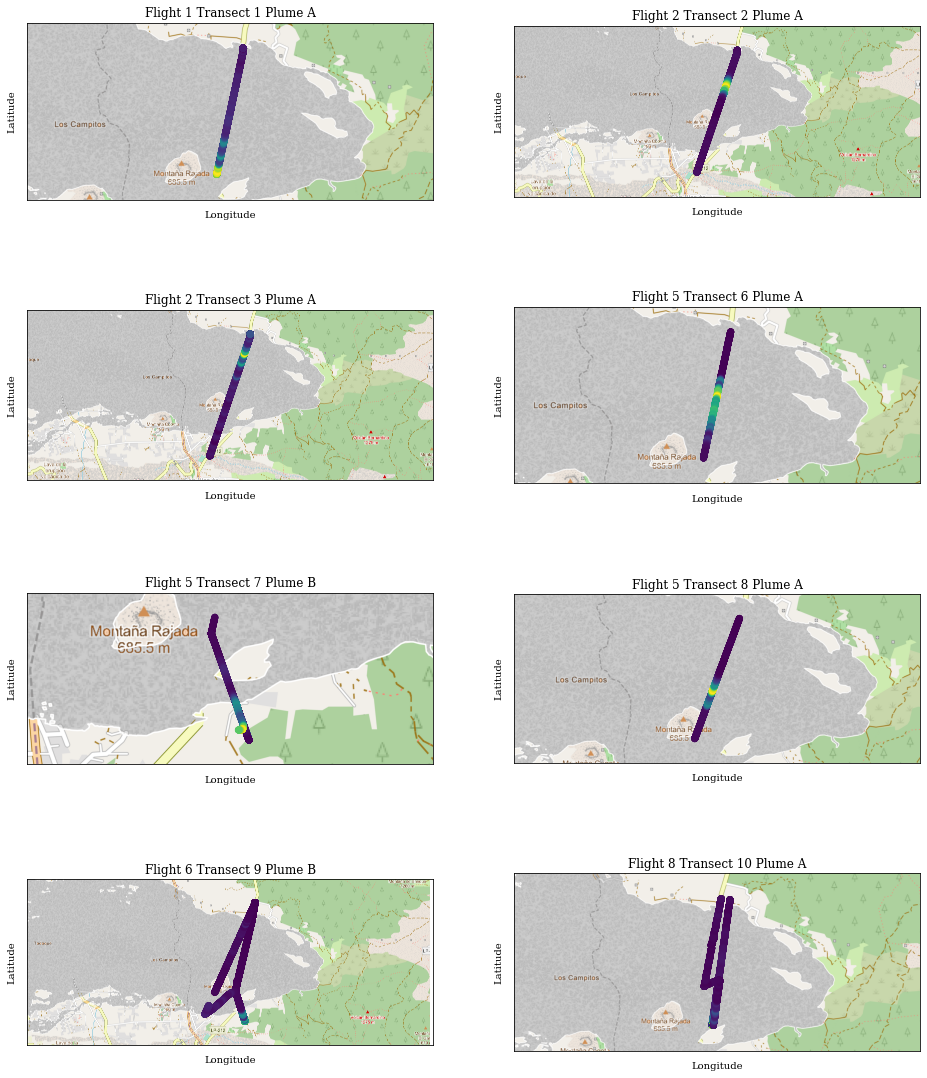

In [8]:
def display_scatter_on_map(readings, title, ax, draw_path=False):
    lat_1 = min([r.lat for r in readings])
    lat_2 = max([r.lat for r in readings])
    lon_1 = min([r.lon for r in readings])
    lon_2 = max([r.lon for r in readings])
    
    plot_scatter(fig, ax, readings, draw_path)

    show(la_palma_map.read(), ax=ax, transform=la_palma_map_original.transform)
    
    zoom_to_data(ax, readings)
    geo_axis_format(ax)
    ax.title.set_text(title)

    ax.plot()

fig, axs = plt.subplots(4, 2, figsize=(16, 20))

display_scatter_on_map(lapalma_flight1, 'Flight 1 Transect 1 Plume A', axs[0,0])
display_scatter_on_map(lapalma_flight2a, 'Flight 2 Transect 2 Plume A', axs[0,1])
display_scatter_on_map(lapalma_flight2b, 'Flight 2 Transect 3 Plume A', axs[1,0])
# display_scatter_on_map((lapalma_flight2a + lapalma_flight2b),'Flight 2 Transect 2+3 Plume A', axs[1,1])
# display_scatter_on_map(lapalma_flight3, 'Flight 3 Transect 4 Plume A', axs[2,0])
# display_scatter_on_map(lapalma_flight4, 'Flight 4 Transect 5 Plume A', axs[2,1])
# display_scatter_on_map(lapalma_flight5, 'Flight 5 Transect 6 + 7 + 8 Plume A',  axs[3,0])
display_scatter_on_map(first_plume, 'Flight 5 Transect 6 Plume A', axs[1, 1])
display_scatter_on_map(curtain_plume, 'Flight 5 Transect 7 Plume B', axs[2,0])
display_scatter_on_map(returning_plume, 'Flight 5 Transect 8 Plume A', axs[2,1])
display_scatter_on_map(lapalma_flight6, 'Flight 6 Transect 9 Plume B', axs[3,0])
display_scatter_on_map(lapalma_flight8, 'Flight 8 Transect 10 Plume A', axs[3,1])

plt.savefig("transects_map.pdf", format="pdf")

Flight 2 Transect 2 Plume A, 516.95, 57.21, 12793.28, 12540.32, 20711.19, 471042.00
Flight 5 Transect 6 Plume A, 597.27, 108.03, 40807.34, 39738.21, 425245.24, 4729978.38
Flight 5 Transect 8 Plume A, 682.30, 62.01, 15847.35, 15746.44, 276950.53, 742689.09
Flight 5 Transect 7, B, 1414.35, 116.20, 15364.54, 12270.59, 1964302.11, 450996.79
Flight 6 Transect 9 Plume B, 1703.81, 95.88, 62233.56, 60282.55, 9762713.98, 10884931.57


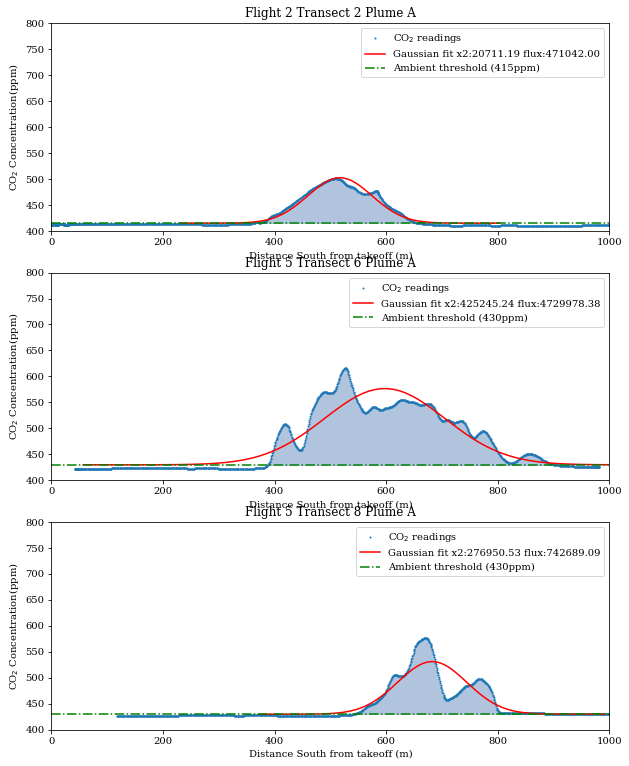

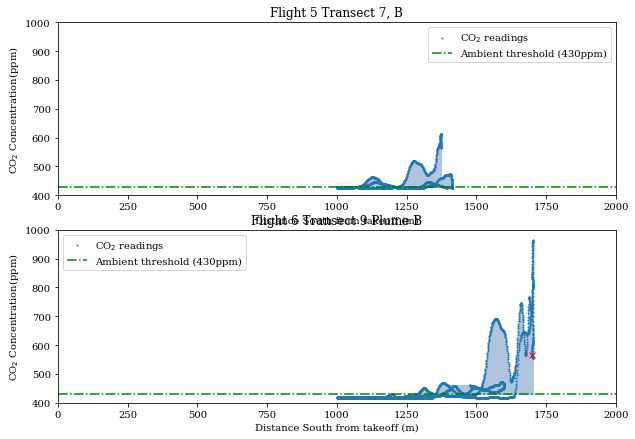

In [58]:
fig, axs = plt.subplots(3, 1, figsize=(10, 13))

render_distance_data(lapalma_flight2a[0], lapalma_flight2a, 415, 'Flight 2 Transect 2 Plume A', axs[0], limit_distance=1000, legend=True)
render_distance_data(lapalma_flight5[0], first_plume, 430, 'Flight 5 Transect 6 Plume A', axs[1], limit_distance=1000, legend=True)
render_distance_data(lapalma_flight5[0], returning_plume, 430, 'Flight 5 Transect 8 Plume A', axs[2], limit_distance=1000, legend=True)
plt.savefig("transect_plumeA.pdf", format="pdf")

def add_collection_marker(ax):
    starting_position = lapalma_flight6[0]
    collection_point_distance = (starting_position.lat - collection_point.lat) * (earthCircumference / 360) * math.cos(starting_position.lat * 0.01745)
    
    ax.plot(collection_point_distance, collection_point.value, color='r', marker='x', zorder=2)

fig, axs = plt.subplots(2, 1, figsize=(10, 7))
render_distance_data(lapalma_flight5[0], curtain_plume, 430, 'Flight 5 Transect 7, B', axs[0], min_distance=1000, limit_distance=2000, legend=True, use_max=True, plot_gaussian=False, max_co2=1000)
render_distance_data(lapalma_flight6[0], lapalma_flight6, 430, 'Flight 6 Transect 9 Plume B', axs[1], min_distance=1000, limit_distance=2000, legend=True, use_max=True, plot_gaussian=False, max_co2=1000, delegate=add_collection_marker)
# render_distance_data(lapalma_flight8[0], lapalma_flight8, 418, 'Flight 8 Transect 10 Plume A', axs[1], limit_distance=2000, legend=True, use_max=True)
plt.savefig("transect_plumeB.pdf", format="pdf")

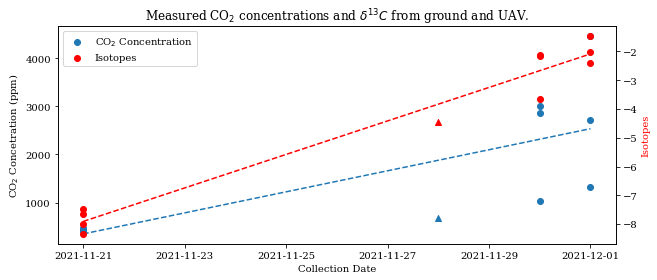

In [59]:
concentrations = [435.42, 471.54, 436.74, 416.00, 671.17, 1029.73, 2998.42, 2863.47, 4458.80, 2722.40, 1326.11]
isotopes = [-7.46, -8.34, -7.65, -8.00, -4.44, -3.65, -2.12, -2.15, -2.03, -1.47, -2.40]
date = ['2021-11-21', '2021-11-21', '2021-11-21', '2021-11-21', '2021-11-28', '2021-11-30', '2021-11-30', '2021-11-30', '2021-12-01', '2021-12-01', '2021-12-01']
date = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in date]
ordinal_date = [d.toordinal() for d in date]
# markers = ['.'] * len(concentrations)
# markers[4] = 'D'
markers = 'o'

def arrayExcept(array, index):
    return array[:index] + array[index+1:]


fig, ax = plt.subplots(figsize=(10, 4))

ax2=ax.twinx()
ax.title.set_text("Measured CO$_2$ concentrations and $\delta^{13}C$ from ground and UAV.")
ax.scatter(arrayExcept(date, 4), arrayExcept(concentrations, 4), label="CO$_2$ Concentration", color='C0', marker='o')
ax.scatter([date[4]], [concentrations[4]], color='C0', marker='^')
ax.scatter([], [], color="red", label="Isotopes", marker='o') 
ax.set_ylabel("CO$_2$ Concetration (ppm)")


ax2.scatter(arrayExcept(date, 4), arrayExcept(isotopes, 4), color="red", marker='o')
ax2.scatter([date[4]], [isotopes[4]], color="red", marker='^')
ax2.set_ylabel("Isotopes",color="red")

ax.legend()

ax.set_xlabel("Collection Date")

def linear_fit(x, y):
    z = np.polyfit(x, y, 1)
    return np.poly1d(z)

concentration_fit = linear_fit(ordinal_date, concentrations)
isotope_fit = linear_fit(ordinal_date, isotopes)

ax.plot(date, concentration_fit(ordinal_date), color='C0', linestyle='--')
ax2.plot(date, isotope_fit(ordinal_date), 'r--')

plt.savefig("table1.pdf", format="pdf")

Flight 2 Transect 2 Plume A, 516.95, 57.21, 12793.28, 12540.32, 20711.21
Flight 5 Transect 6 Plume A, 597.27, 108.03, 40807.34, 39738.21, 425245.24
Flight 5 Transect 8 Plume A, 682.30, 62.01, 15848.25, 15746.44, 276950.53
Flight 5 Transect 7, B, 1414.35, 116.19, 5989.54, 12269.92, 1964320.53
Flight 6 Transect 9 Plume B, 1703.81, 225.77, 24575.26, 88214.16, 18077911.97


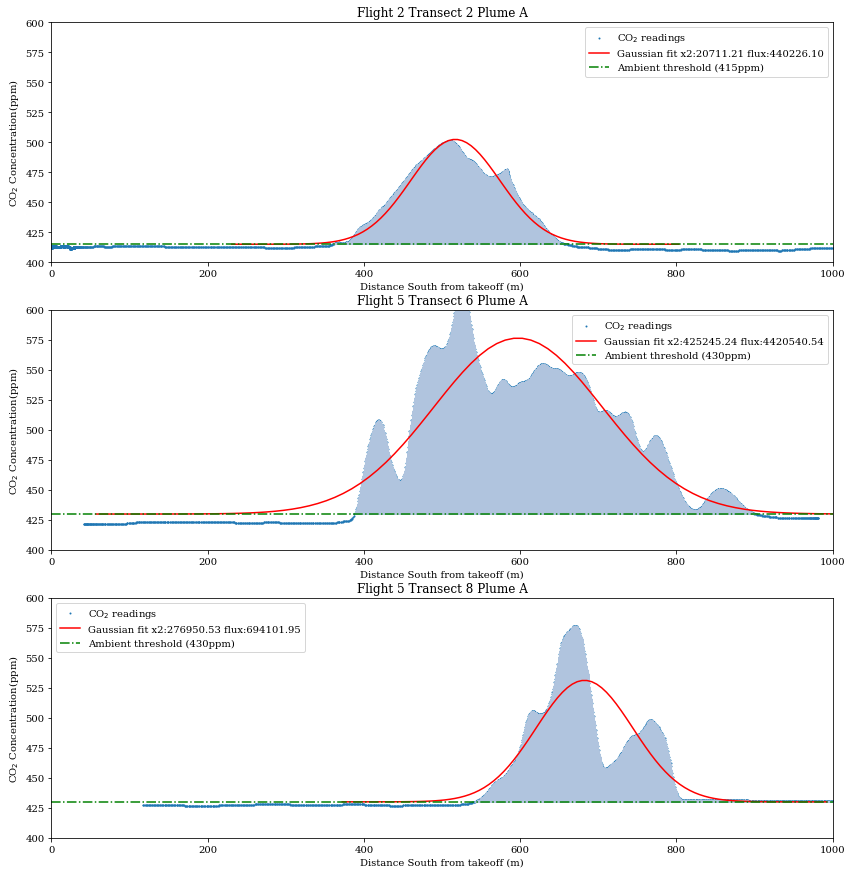

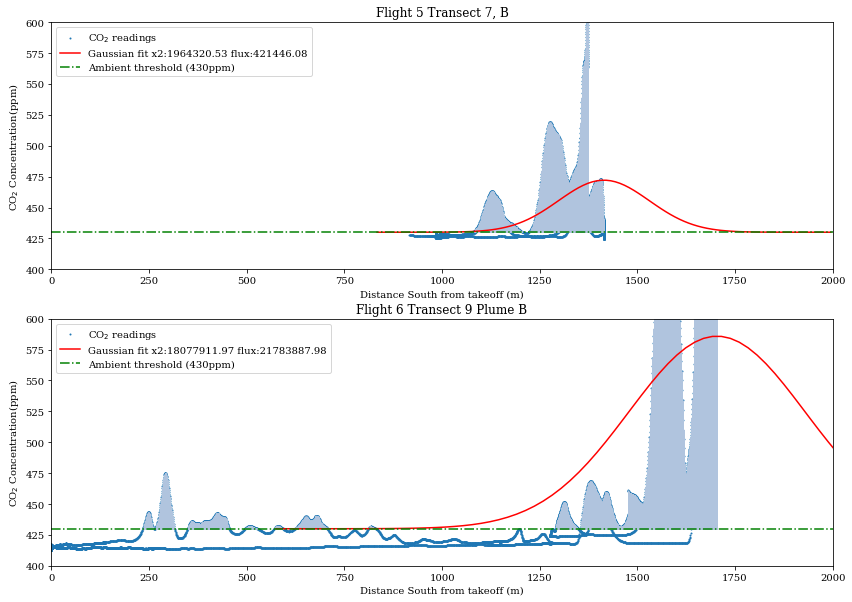

In [34]:
def render_area_data(starting_position, data, ambient, title, ax, limit_distance=None, legend=True, use_max=False):
    total = 0
    count = 0
    
    
    
    distance_data = []
    max_distance = 0
    for d in data:
        lat_diff = (starting_position.lat - d.lat) * (earthCircumference / 360) * math.cos(starting_position.lat * 0.01745)
#         lat_diff = (starting_position.lat - d.lat) * (earthCircumference / 360) * math.cos(starting_position.lat * 0.01745)
#         lon_diff = (starting_position.lon - d.lon) * (earthCircumference / 360)
#         distance = math.sqrt((lat_diff*lat_diff) + (lon_diff*lon_diff))
        distance = lat_diff
        distance_data.append({"distance": distance, "value": d.value})
        if(distance > max_distance):
            max_distance = distance
            
    distance_data.sort(key=lambda v: v["distance"])
            
    for i in range(len(distance_data)):
        if distance_data[i]["value"] > ambient:
            relative_co2 = distance_data[i]["value"] - ambient
            total = total + (relative_co2 * distance_data[i]["distance"])
            count = count + relative_co2
            
#     print(count)
        
    mean = max_distance if use_max else total / count
    
    std_total = 0
    for i in range(len(distance_data)):
        if distance_data[i]["value"] > ambient:
            relative_co2 = distance_data[i]["value"] - ambient
            distance_diff = distance_data[i]["distance"] - mean
            std_total = std_total + (relative_co2 * (distance_diff * distance_diff))
    m = len(distance_data)
#     print("m: {} count: {}".format(m, count))
    std_dev = math.sqrt(std_total / (((m-1) / m) * count))
    
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(((-(((x - mean) / stddev) ** 2)) / 2)) / (stddev * math.sqrt(2 * math.pi))


    def difference(s):
        difference_sum = 0
        for i in range(len(distance_data)) :
            if distance_data[i]["value"] > ambient:
                calculated_value = gaussian(distance_data[i]["distance"], s, mean, std_dev)
                calculated_difference = distance_data[i]["value"] - ambient
                difference = calculated_value - calculated_difference
                difference_sum = difference_sum + (difference ** 2)
        return difference_sum
    
    def gradient_descent(current, step_size, max_iter):
        current_x = current
        prev_difference = 1
        rate = 1
        precision = 0.00001
        previous_step_size = step_size
        
        for i in range(max_iter):
            previous_x = current_x
            
            value = difference(previous_x)
            value_plus = difference(previous_x + (previous_step_size * 0.1))
            
            df = (value_plus - value) / (step_size * 0.1)
            
            current_x = current_x - (rate * df)
            
#             print("Iteration",i,"\nX value is",current_x)
            
        
#         print("The local minimum occurs at", current_x)
        return [current_x, difference(current_x)]

    def flux(C):
        return math.pow((C * 44.01 / 24.45), 2) *10 * math.pow(10, -9) * 60 * 60 * 24
    
    def area():
        
        area_sum = 0
        size = len(distance_data)
        for i in range(size):
            if distance_data[i]["value"] > ambient:
                left = (distance_data[i-1]["distance"] + distance_data[i]["distance"]) / 2 if i > 0 else distance_data[i]["distance"]
                right = (distance_data[i]["distance"] + distance_data[i+1]["distance"]) / 2 if i < size - 1 else distance_data[i]["distance"]
                area_sum += (distance_data[i]["value"] - ambient) * abs(right - left)
        
        return area_sum
    
    def render_scatter_areas(ax):
        
        size = len(distance_data)
        for i in range(size):
            if distance_data[i]["value"] > ambient:
                left = (distance_data[i-1]["distance"] + distance_data[i]["distance"]) / 2 if i > 0 else distance_data[i]["distance"]
                right = (distance_data[i]["distance"] + distance_data[i+1]["distance"]) / 2 if i < size - 1 else distance_data[i]["distance"]
                ax.add_patch(Rectangle((left, ambient), right - left, distance_data[i]["value"] - ambient, color='lightsteelblue'))
    
    [minimum_s, minimum_x2] = gradient_descent(0, 100, 1000)
    
    scatter_area = area()

#     print(title)
#     print('Gaussian fit (m:{:.2f} s:{:.2f} a:{:.2f} x2:{:.2f})'.format(mean, std_dev, minimum_s, minimum_x2))
#     print("flux:{:.2f}".format(flux(minimum_s)))
#     print("mean {} stdev: {}".format(mean, std_dev))
#     print("Average: {}".format((total / count)) )
    print("{}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}".format(title, mean, std_dev, scatter_area, minimum_s, minimum_x2, flux(minimum_s)))
        
    x = np.linspace(mean - 5*std_dev, mean + 5*std_dev, 100)
    pdf = [(x) + ambient for x in gaussian(x, minimum_s, mean, std_dev)]
    
    ax.title.set_text(title)
    ax.scatter([d["distance"] for d in distance_data], [d["value"] for d in distance_data], s=1, label="CO$_2$ readings")
    ax.plot(x, pdf, c='r', label='Gaussian fit x2:{:.2f} flux:{:.2f}'.format(minimum_x2, flux(minimum_s)))
    ax.axhline(y = ambient, color = 'g', linestyle = '-.', label="Ambient threshold ({}ppm)".format(ambient))
    render_scatter_areas(ax)
    ax.set_xlabel('Distance South from takeoff (m)')
    ax.set_ylabel('CO$_2$ Concentration(ppm)')
    if limit_distance is not None:
        ax.set_aspect('auto')
        ax.set_xlim(0, limit_distance)
        
    ax.set_ylim(400, 600)
    if legend:
        ax.legend()
    ax.plot()

fig, axs = plt.subplots(3, 1, figsize=(14, 15))

render_area_data(lapalma_flight2a[0], lapalma_flight2a, 415, 'Flight 2 Transect 2 Plume A', axs[0], limit_distance=1000, legend=True)
render_area_data(lapalma_flight5[0], first_plume, 430, 'Flight 5 Transect 6 Plume A', axs[1], limit_distance=1000, legend=True)
render_area_data(lapalma_flight5[0], returning_plume, 430, 'Flight 5 Transect 8 Plume A', axs[2], limit_distance=1000, legend=True)
plt.savefig("transect_plumeA_areas.pdf", format="pdf")

fig, axs = plt.subplots(2, 1, figsize=(14, 10))

render_area_data(lapalma_flight5[0], curtain_plume, 430, 'Flight 5 Transect 7, B', axs[0], limit_distance=2000, legend=True, use_max=True)
render_area_data(lapalma_flight6[0], lapalma_flight6, 430, 'Flight 6 Transect 9 Plume B', axs[1], limit_distance=2000, legend=True, use_max=True)
# render_area_data(lapalma_flight8[0], lapalma_flight8, 418, 'Flight 8 Transect 10 Plume A', axs[1], limit_distance=2000, legend=True, use_max=True)
plt.savefig("transect_plumeB_areas.pdf", format="pdf")